

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://gym.openai.com/envs/CartPole-v1/)).


##Libraries

In [1]:
#!pip install gym[Box_2D]
#!pip install box2d-py
#!pip install pyglet

In [2]:
import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import keras.backend as K
from tensorflow.keras.regularizers import l2
import random
import tensorflow as tf

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Hyperparameters

In [4]:
GAMMA = 0.99

MEMORY_SIZE = 200000
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 2000
MAX_STEPS = 1000
K_STEPS = 1000
TRAIN_STEPS = 4
SAVE_STEPS = 2048
FINISH_STEPS = 102400
REGULARIZER_FACTOR = 0.001

## Class ReplayMemory

Memory of transitions for experience replay.

In [5]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1
        
        if self.current_size >= MEMORY_SIZE - 1:
            self.current_size = 0
            

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [6]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.Dense(64, input_shape=(number_of_observations,),
                                          activation="relu" ,kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(64, activation="relu" ,kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(64, activation="relu" ,kernel_initializer="he_normal"))
        self.model.add(keras.layers.Dense(number_of_actions, activation="linear", kernel_regularizer=l2(REGULARIZER_FACTOR)))
        self.model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        # self.model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum = 0.9))
        self.model.save("model1.h5")
        self.target_model = keras.models.load_model("model1.h5")
        #self.target_model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        # self.model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum = 0.9))

    def masked_huber_loss(self, mask_value, clip_delta):
        def f(y_true, y_pred):
            error = y_true - y_pred
            cond  = K.abs(error) < clip_delta
            mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
            masked_squared_error = 0.5 * K.square(mask_true * (y_true - y_pred))
            linear_loss  = mask_true * (clip_delta * K.abs(error) - 0.5 * (clip_delta ** 2))
            huber_loss = tf.where(cond, masked_squared_error, linear_loss)
            return K.sum(huber_loss) / K.sum(mask_true)
        f.__name__ = 'masked_huber_loss'
        return f    
    
    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        q_targets = self.model.predict(states)
        q_next_states = self.target_model.predict(next_states)

        for i in range(BATCH_SIZE):
            if (terminal_states[i]):
                q_targets[i][actions[i]] = rewards[i]
            else:
                q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])

        self.model.train_on_batch(states, q_targets)

        # Copy model to target model
        if total_steps % K_STEPS == 0:
            self.model.save("model1.h5")
            self.target_model = keras.models.load_model("model1.h5")
            #self.target_model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

    def add_score(self, score):
        # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")         

## Environment Cartpole

Cartpole simulator from [Open Ai Gym](https://gym.openai.com/envs/CartPole-v1/):

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: position
- state[1]: velocity
- state[2]: angle
- state[3]: angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

In [7]:
def create_environment():
    # Create simulated environment
    environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

In [8]:
def test(a):
    env_name = 'LunarLander-v2'       
    env = gym.make(env_name)
    state = env.reset()
    score = 0
    scores = []

    done = False
    for ii in range(10):
        while done == False:
            action = a.select(state)
            state, reward, done, _ = env.step(action)
            score += reward
        done = False
        scores.append(score)
        score = 0
        state = env.reset()

    env.close()
    scores_step = sum(scores)/10
    return scores_step

## Main program




Last reward:  -100
Episode   1: Average score -133.66950006660284 (exploration rate: 0.99, transitions: 94)
Score:  -133.66950006660284
Last reward:  -100
Episode   2: Average score -177.49480076383327 (exploration rate: 0.99, transitions: 182)
Score:  -221.3201014610637
Last reward:  -100
Episode   3: Average score -136.57782153914184 (exploration rate: 0.99, transitions: 252)
Score:  -54.74386308975899
Last reward:  -100
Episode   4: Average score -127.26270681465576 (exploration rate: 0.98, transitions: 380)
Score:  -99.31736264119752
Last reward:  -100
Episode   5: Average score -168.62395462029409 (exploration rate: 0.98, transitions: 462)
Score:  -334.06894584284737
Last reward:  -100
Episode   6: Average score -177.7600897131795 (exploration rate: 0.97, transitions: 589)
Score:  -223.44076517760664
Last reward:  -100
Episode   7: Average score -224.05663957584392 (exploration rate: 0.97, transitions: 708)
Score:  -501.8359387518304
Last reward:  -100
Episode   8: Average score -

Last reward:  -100
Episode  61: Average score -134.6042336291971 (exploration rate: 0.74, transitions: 6500)
Score:  -173.39683762176648
Last reward:  -100
Episode  62: Average score -134.34018904046425 (exploration rate: 0.73, transitions: 6649)
Score:  -118.23346912776078
Last reward:  -100
Episode  63: Average score -135.57458575744087 (exploration rate: 0.73, transitions: 6728)
Score:  -212.10718220999044
Last reward:  -100
Episode  64: Average score -134.27177923338502 (exploration rate: 0.73, transitions: 6832)
Score:  -52.19496821786623
Last reward:  -100
Episode  65: Average score -133.49644576267377 (exploration rate: 0.72, transitions: 6999)
Score:  -83.87510363715337
Last reward:  -100
Episode  66: Average score -133.91735930127183 (exploration rate: 0.72, transitions: 7083)
Score:  -161.27673931014562
Last reward:  -100
Episode  67: Average score -132.50046475584173 (exploration rate: 0.71, transitions: 7161)
Score:  -38.985424757455135
Last reward:  -100
Episode  68: Avera

Last reward:  -100
Episode 121: Average score -108.68522793843881 (exploration rate: 0.55, transitions: 14279)
Score:  -33.643666544950136
Last reward:  -100
Episode 122: Average score -107.84935021505322 (exploration rate: 0.54, transitions: 14431)
Score:  -33.12214586395416
Last reward:  -100
Episode 123: Average score -106.40928090391043 (exploration rate: 0.54, transitions: 14531)
Score:  -36.642337652746654
Last reward:  -100
Episode 124: Average score -105.00854125382003 (exploration rate: 0.54, transitions: 14836)
Score:  -72.17178157121765
Last reward:  -100
Episode 125: Average score -102.72579323120003 (exploration rate: 0.53, transitions: 14937)
Score:  -78.55191323149161
Last reward:  -100
Episode 126: Average score -101.58197013509307 (exploration rate: 0.53, transitions: 15088)
Score:  -71.37556126489523
Last reward:  -100
Episode 127: Average score -101.28894863056476 (exploration rate: 0.53, transitions: 15287)
Score:  -64.49238850014298
Last reward:  -100
Episode 128: 

Last reward:  -100
Episode 181: Average score -66.90336148008913 (exploration rate: 0.40, transitions: 24422)
Score:  -65.13039738403766
Last reward:  -100
Episode 182: Average score -67.27153230690756 (exploration rate: 0.40, transitions: 24541)
Score:  -68.76217902793343
Last reward:  -100
Episode 183: Average score -66.94299485314212 (exploration rate: 0.40, transitions: 24694)
Score:  -33.531738247839215
Last reward:  -100
Episode 184: Average score -65.6976009442796 (exploration rate: 0.40, transitions: 24846)
Score:  -33.51197463975416
Last reward:  -100
Episode 185: Average score -65.11643553268802 (exploration rate: 0.40, transitions: 24955)
Score:  -16.601586066981355
Last reward:  -100
Episode 186: Average score -64.03329085780081 (exploration rate: 0.39, transitions: 25204)
Score:  -41.0588573356384
Last reward:  -100
Episode 187: Average score -63.79541295484773 (exploration rate: 0.39, transitions: 25345)
Score:  -19.77828557947724
Last reward:  -100
Episode 188: Average s

Last reward:  -100
Episode 240: Average score -65.32142636567693 (exploration rate: 0.30, transitions: 45292)
Score:  -152.38260096683896
Last reward:  -100
Episode 241: Average score -65.30201100214171 (exploration rate: 0.30, transitions: 46045)
Score:  -252.54573550725968
Last reward:  0.8156567385479832
Episode 242: Average score -65.71729522234686 (exploration rate: 0.30, transitions: 47045)
Score:  -33.78448892046906
Last reward:  -100
Episode 243: Average score -64.53130232953812 (exploration rate: 0.30, transitions: 47212)
Score:  -126.01067008934481
Last reward:  -1.1882723742778996
Episode 244: Average score -64.68320420623245 (exploration rate: 0.29, transitions: 48212)
Score:  -45.51800852246232
Last reward:  1.904496563887727
Episode 245: Average score -64.63489940959752 (exploration rate: 0.29, transitions: 49212)
Score:  -24.39406357581163
Last reward:  0.0017933183742222525
Episode 246: Average score -63.283861050435824 (exploration rate: 0.29, transitions: 50212)
Score

Last reward:  -3.7597813694016446
Episode 296: Average score -44.21123342210116 (exploration rate: 0.23, transitions: 93323)
Score:  35.01703685089969
Last reward:  -12.235340713723751
Episode 297: Average score -43.42603939225578 (exploration rate: 0.23, transitions: 94323)
Score:  44.73736602822781
Last reward:  0.24696608928450986
Episode 298: Average score -43.43190828734566 (exploration rate: 0.22, transitions: 95323)
Score:  -6.8163543550090635
Last reward:  0.6621874443493578
Episode 299: Average score -42.80339081429238 (exploration rate: 0.22, transitions: 96323)
Score:  9.313992509328566
Last reward:  -100
Episode 300: Average score -43.82053887243962 (exploration rate: 0.22, transitions: 97145)
Score:  -152.62597037692174
Last reward:  -0.45677077076814565
Episode 301: Average score -40.49777443035161 (exploration rate: 0.22, transitions: 98145)
Score:  83.57932535159159
Last reward:  100
Episode 302: Average score -38.28086504998687 (exploration rate: 0.22, transitions: 989

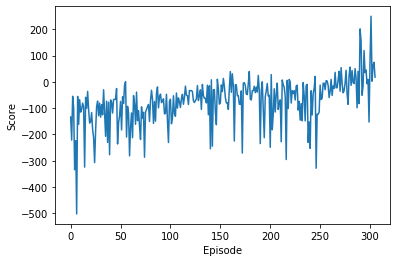

In [9]:
import time
environment, number_of_observations, number_of_actions = create_environment()
agent = DQN(number_of_observations, number_of_actions)
episode = 0
goal_reached = False
start_time = time.perf_counter()
scores = []
total_steps = 1
rew_step = []
start = time.time()
while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    
    if total_steps > FINISH_STEPS:
        break
    
    episode += 1
    step = 1
    end_episode = False
    state = environment.reset()
    reward_accumulated = 0
    # Decrease exploration rate
    agent.exploration_rate *= EXPLORATION_DECAY
    agent.exploration_rate = max(EXPLORATION_MIN, agent.exploration_rate)
    
    
    
    while not (end_episode):
        # Select an action for the current state
        action = agent.select(state)

        # Execute the action on the environment
        state_next, reward, terminal_state, info = environment.step(action)

        #if episode == NUMBER_OF_EPISODES:
            #environment.render()

        # Store in memory the transition (s,a,r,s')
        agent.remember(state, action, reward, state_next, terminal_state)

        # print(state[0],reward)

        # Learn using a batch of experience stored in memory
        if total_steps % TRAIN_STEPS == 0:
            agent.learn()
        
        #if total_steps % SAVE_STEPS == 0:
        #    rew_step.append(test(agent))
        #    print('Guardo')
        
        if total_steps > FINISH_STEPS:
            break
              
        # Detect end of episode
        if terminal_state:
            print('Last reward: ', reward)
            reward_accumulated += reward
            agent.add_score(reward_accumulated)
            scores.append(reward_accumulated)
            if episode < 100:
                avg_score = sum(scores)/len(scores)
            else:
                avg_score = sum(scores[-100:])/100
            if avg_score >= 200:
                goal_reached = True
            print("Episode {0:>3}: ".format(episode), end='')
            print("Average score {0:>3} ".format(avg_score), end='')
            # print("estado: ", state)
            print("(exploration rate: %.2f, " % agent.exploration_rate, end='')
            print("transitions: " + str(agent.memory.current_size) + ")")
            print("Score: ", reward_accumulated)
            end_episode = True
        else:
            state = state_next
            step += 1
            total_steps += 1
            reward_accumulated += reward

counter_file = 2
NAME2 = 'DQN_lunarlander_steps_' + str(counter_file) + '.txt'            

'''
output_file2 = open(NAME2, 'w')
for rew in rew_step:
    output_file2.write(str(rew) + '\n')

output_file2.close()
'''
print("Time: ", ((time.time() - start) / 60))
environment.close()
if goal_reached:
    print("Reached goal sucessfully.")
else:
    print("Failure to reach the goal.")



agent.display_scores_graphically()